In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation

from sympy.utilities.iterables import multiset_permutations
import matplotlib.pyplot as plt
from pygmo import non_dominated_front_2d as nd2


In [2]:
def evaluate(g, route):
    scenic_score = 0
    distance = 0
    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i+1]
        scenic_score += g.get_edge_data(route[i], route[i+1])['scenic_score']
        distance += g.get_edge_data(route[i], route[i+1])['distance']
    return distance, scenic_score

In [3]:
rl = 10 # route length
df = pd.read_csv('bicycle_network.csv')
df['score'] = np.sum(df[['scenic_beauty', 'roughness', 'safety', 'slope']], axis=1)
df = df[['node1', 'node2', 'distance', 'score']]
df = df.loc[(df.node1 < rl) & (df.node2 < rl)]
df = df.reset_index(drop=True)

In [4]:
g = nx.Graph()
for node1 in range(rl):
    for node2 in range(rl):
        if node1 == node2:
            continue
        g.add_edge(node1,
                   node2,
                   distance=df.loc[(df.node1 == node1) & (df.node2 == node2), 'distance'].values[0],
                   scenic_score=df.loc[(df.node1 == node1) & (df.node2 == node2), 'score'].values[0])

## Brute Force approach

In [5]:
results = []
for route in multiset_permutations(np.arange(rl)):
    results.append(evaluate(g, route))
results = np.array(results)

results2 = results.copy()
results2[:, 1] = -results2[:, 1]
idx = nd2(results2)
pareto_front = results[idx]


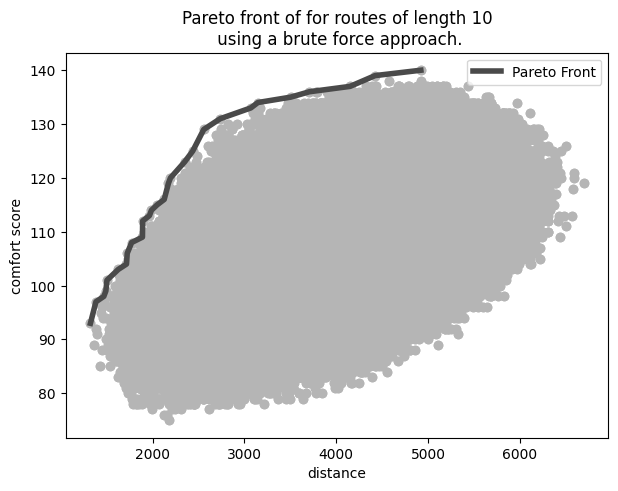

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(results[:, 0], results[:, 1], c='#b5b5b5')
ax.plot(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', c='#4a4a4a', linewidth=4)
ax.set_xlabel('distance')
ax.set_ylabel('comfort score')
ax.legend()
ax.set_title(f'Pareto front of for routes of length {rl}\n using a brute force approach.')
plt.show()

## GA approach

In [7]:
class BicycleRoutingProblem(ElementwiseProblem):
    def __init__(self, graph):
        super().__init__(
            n_var=rl, n_obj=2, n_constr=0,
            xl=np.zeros(rl), xu=np.ones(rl) * (rl - 1), type_var=int
        )
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        scenic_score = 0
        distance = 0
        x = np.floor(x).astype(int)
        for i in range(len(x) - 1):
            scenic_score += self.graph.get_edge_data(x[i], x[i+1])['scenic_score']
            distance += self.graph.get_edge_data(x[i], x[i+1])['distance']

        out['F'] = [distance, -scenic_score]

class FixStartPoint(Repair):
    def _do(self, problem, X, **kwargs):
        # Assuming we are always starting from node 0
        I = np.where(X == 0)[1]
        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])
        return X


problem = BicycleRoutingProblem(g)
algorithm = NSGA2(
    pop_size=1000,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=OrderCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True,
    repair=FixStartPoint()
)
termination = DefaultMultiObjectiveTermination(n_max_gen=500)

res = minimize(problem,
               algorithm,
               termination,
               save_history=True,
               verbose=True)



Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      998 |     12 |             - |             -
     2 |     1098 |     14 |  0.0127685288 |             f
     3 |     1198 |     15 |  0.0606060606 |         ideal
     4 |     1298 |     16 |  0.0103861331 |             f
     5 |     1398 |     16 |  0.000000E+00 |             f
     6 |     1498 |     15 |  0.0130356940 |             f
     7 |     1598 |     15 |  0.000000E+00 |             f
     8 |     1698 |     16 |  0.0056811157 |             f
     9 |     1798 |     18 |  0.0571428571 |         ideal
    10 |     1898 |     18 |  0.0018639931 |             f
    11 |     1998 |     18 |  0.0034518392 |             f
    12 |     2098 |     18 |  0.000000E+00 |             f
    13 |     2198 |     18

In [8]:
np.save(f'results/pareto_front_{rl}_nodes.npy', res.F)
results = np.load('results/pareto_front_10_nodes.npy')
x = results[:, 0]
y = results[:, 1]
I = np.argsort(x)
y = y[I]
x = x[I]

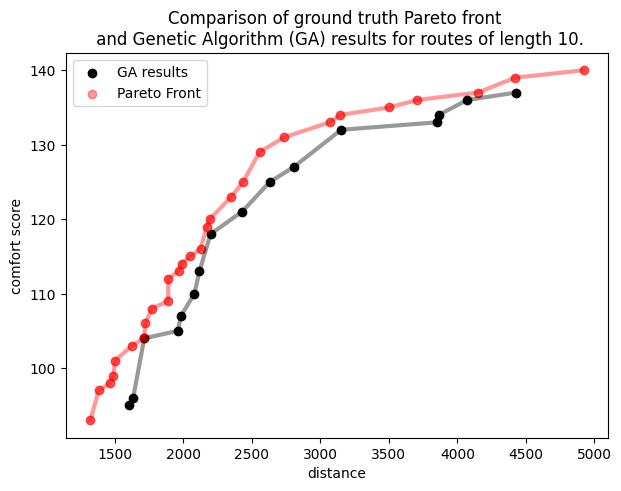

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.scatter(x, -y, label='GA results', c='k')
ax.plot(x, -y, alpha=0.4, linewidth=3, c='k')
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', c='r', alpha=0.4)
ax.plot(pareto_front[:, 0], pareto_front[:, 1], c='r', linewidth=3, alpha=0.4)
ax.legend()
ax.set_xlabel('distance')
ax.set_ylabel('comfort score')
ax.set_title(f'Comparison of ground truth Pareto front \n and Genetic Algorithm (GA) results for routes of length {rl}.')
plt.show()